# 18650 Battery Life: Survival Analysis vs Machine Learning

### Aryan Bhardwaj, Cormac Dacker, Tyler Gomez Riddick, Avery Pike

## Data Preprocessing

### Data Loading

The data for this project are the entire life-cycle of 26 battery packs consisting of two 18650 battery, which are rechargeable lithium-ion batteries. Each of the 26 battery packs has its own dedicated CSV, recording data about the battery once per second during the charging, rest, and discharging phases. Because there are only 26 battery packs in these data, we decided to focus on the discharge phases only, as each battery pack has several discharge phases through it's lifecycle. First though, we have to load in the data, and there is a lot of it (a few million rows per csv on average).

Because all of the battery data were stored in separate CSVs, we first needed to combine each group (regular, second life, recommissioned) into their own CSV consisting of all of the battery packs in that dataset.

In [1]:
import os
import glob  # pip install glob2
import pandas as pd
import warnings
import time
import tqdm  # pip install tqdm
import numpy as np


In [5]:
csv_paths = ['/battery_alt_dataset/regular_alt_batteries',
             '/battery_alt_dataset/second_life_batteries',
             '/battery_alt_dataset/recommissioned_batteries'
]

#root = os.path.dirname(os.path.abspath('csv_combine.py'))
root = os.getcwd()


def concatinateCSVs(folderPath, ignore_list=[]):  # combines all csv files in a folder into df
    warnings.filterwarnings("ignore")
    os.chdir(folderPath)
    # all the filenames with a .csv format
    allFilenames = [i for i in glob.glob("*.{}".format("csv"))]
    combinedFilesData = []
    for file in tqdm.tqdm(allFilenames, desc='Combining ' + folderPath.split('/')[-1]):
        if file in ignore_list:
            continue
        try:
            df = pd.read_csv(file)
            combinedFilesData.append(df)
        except pd.errors.EmptyDataError:
            print(file, "is empty")
            continue
        except pd.errors.ParserError:
            print(file, "parse error")
            continue
    try:  # concatinate all csv data in a folder
        combinedFilesData = pd.concat([file for file in combinedFilesData], )
    except ValueError:
        combinedFilesData = []
    os.chdir(root)
    return pd.DataFrame(combinedFilesData)


def combine_csvs(csv_paths):  # builds the one files from folders
    for csv_path in csv_paths:
        (concatinateCSVs(root + csv_path,
                         ignore_list=['battery40.csv', 'battery41.csv',
                                      'battery50.csv', 'battery51.csv']).to_csv(root + csv_path + '.csv', index=False))

        return


def convert_to_preferred_format(sec):  # only to be fancy
    sec = sec % (24 * 3600)
    sec %= 3600
    min = sec // 60
    sec %= 60
    return "%02d:%02d" % (min, sec)


if __name__ == '__main__':
    start_time = time.time()
    combine_csvs(csv_paths)
    print('Time taken:', convert_to_preferred_format(time.time() - start_time))


/Users/leotyler/venv/GitHub/18650-Accelerated-Battery-Life-Testing
/Users/leotyler/venv/GitHub/18650-Accelerated-Battery-Life-Testing


Combining recommissioned_batteries: 100%|██████████| 8/8 [00:05<00:00,  1.39it/s]


Time taken: 00:51


### Data Combining: Reducing Dischrge Phases

Because we are focusing on only the discharge phases, we want to break each of the battery datasets into their discharge phases, and then find the average voltage, temperature, and current for each discharge cycle. This will reduce each discharge phase down to a single row instead of the millions we have. To start, we have to load in the new datasets and process them.

In [6]:
# Numbering each distinct discharge phase
def battLabeller(df):
    '''
    df - battery dataset
    feed battery dataset, add column to denote discharge phase
    '''
    label = 1
    df['dischargePhase'] = 0
    for time in tqdm.tqdm(range(len(df['start_time'])-1), total=len(df['start_time'])-1):
        if df['mode'][time] == -1:
            df.at[time, 'dischargePhase'] = label
            if df['mode'][time+1] == 0 or df['mode'][time+1] == 1:
                label += 1
    return df

In [7]:
# This function calculates the time it takes the battery pack in a phase to
# discharge its charge
def timeFinder(df):
    '''
    df - dataframe
    takes dataframe and finds time from start of phase to end of phase
    '''
    df['startTime'] = 0
    df['finishTime'] = 0
    for phase in tqdm.tqdm(df['dischargePhase'].unique(), total=len(df['dischargePhase'].unique())):
        currPhase = df[df['dischargePhase'] == phase]

        # Find start and end time
        start = currPhase['time'].iloc[0] 
        finish = currPhase['time'].iloc[-1]
        
        # Update start and end time
        df.loc[df['dischargePhase'] == phase, 'startTime'] = start
        df.loc[df['dischargePhase'] == phase, 'finishTime'] = finish
    return df

In [8]:
def process_battery_data(df):
    '''
    Takes in df of battery data and reduces each phase
    to a single row, averaging temp, voltage, and current
    and finding the time to death for each discharge phase
    
    Parameters:
    df (dataFrame): input df of battery data sent through
    battLabeller and timeFinder
    
    Returns:
    df (transformed): averaged values and new column
    end_time which is the difference of finishTime and startTime
    '''
    # Run battery df through functions time_end via difference
    df = battLabeller(df)
    df = df[df['mode'] != 0]
    df = df[df['mode'] != 1]
    df = timeFinder(df)
    cols = ['voltage_charger','temperature_battery','current_load','dischargePhase','startTime','finishTime']
    df = df[cols]
    df = df.dropna(subset=['dischargePhase'])
    
    df['time_end'] = (df['finishTime'] - df['startTime'])
    
    # Cast columns to floats
    numeric_cols = ['voltage_charger','temperature_battery','current_load']
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col],errors = 'coerce')
    
    # Group by dischargePhase and aggregate other columns
    aggregated_df = df.groupby('dischargePhase').agg({
        'voltage_charger':'mean',
        'temperature_battery':'mean',
        'current_load':'mean',
        'time_end':'first'
    }).reset_index()
    aggregated_df['mode'] = 1
    
    return aggregated_df

In [9]:
# Read in combined csvs
regular = pd.read_csv('battery_alt_dataset/regular_alt_batteries.csv')
second = pd.read_csv('battery_alt_dataset/second_life_batteries.csv')
recommissioned = pd.read_csv('battery_alt_dataset/recommissioned_batteries.csv')

# Run through the battery data processor
regular = process_battery_data(regular)
second = process_battery_data(second)
recommissioned = process_battery_data(recommissioned)

# Write to new csvs
regular.to_csv('regular.csv')
second.to_csv('second.csv')
recommissioned.to_csv('recommissioned.csv')

100%|██████████| 3626/3626 [00:13<00:00, 274.68it/s]


# Survival Analysis and Weibull Regression

All of the survival analysis done on these data was performed in R, due to our group's familiarity with working in the language with survival analysis. Thus, the next sections of this notebook will not be able to render the work we did, but the R markdowns will be included as part of the submission.

```{r}
library(fitdistrplus)
library(survminer)
library(tidyverse)
library(ggplot2)
library(survival)
library(skimr)

regular = read_csv('regular.csv')
recom = read_csv('recommissioned.csv')
second = read_csv('second.csv')
```

Filtering out times shorter than 10 seconds or NaN values, and temperatures measured at 0. Calculating the Arrhenius temperature and the log voltage for use in the survival analysis models. Additionally, adding in a column for failure (needed for the survival analysis). Assume everywhere "data" occurs that it is filled with one of the three battery DataFrames.

```{r}
# filter out temps < 0
data = data %>% filter(temperature_battery > 0)

# drop times at 0
data = data %>% filter(time_end > 10)

# add a col for failure (they all failed)
data$failure = 1

# drop instances where time_end is NA or 0
data = data %>% filter(!is.na(time_end) & time_end != 0)
```

Performing the Weibull regression using the current_load, log_volt, and arr_temp columns. No interaction terms. Values shown below are for the regular batteries (regular.csv)

```{r}
weibull_fit = survreg(Surv(time_end, failure) ~ current_load +
  log_volt +
  arr_temp
                      , data = data, dist = "weibull")
summary(weibull_fit)
```
```{r}
                        Value Std. Error       z       p
(Intercept)          2.640372   0.140380   18.81 < 2e-16
current_load        -0.081932   0.001081  -75.79 < 2e-16
voltage_charger      0.780425   0.020004   39.01 < 2e-16
temperature_battery -0.001641   0.000416   -3.95 7.9e-05
Log(scale)          -1.754017   0.011486 -152.71 < 2e-16

Scale= 0.173 

Weibull distribution
Loglik(model)= -23355.7   Loglik(intercept only)= -27754.5
	Chisq= 8797.56 on 3 degrees of freedom, p= 0 
Number of Newton-Raphson Iterations: 9 
n= 3743 
```

Next, computing the relevant model metrics: mean squared error (MSE), Akaike information criterion (AIC), and R-squared. Below are the results for the regular batteries. The submitted R-markdown file will show the results for all three datasets.

```{r}
model_metrics = function(model, regular) {
  pred = predict(model, type = "response")
  mse = mean((pred - regular$time_end)^2)
  aic = AIC(model)
  r2 = 1 - mse / var(regular$time_end)
  print("MSE:")
  print(mse)
  print("AIC:")
  print(aic)
  print("R^2:")
  print(r2)
  return(c(mse, aic, r2))
}
model_metrics(weibull_fit, regular)

[1] "MSE:"
[1] 42707.18
[1] "AIC:"
[1] 46756.98
[1] "R^2:"
[1] 0.8550565
[1] 4.270718e+04 4.675698e+04 8.550565e-01
```

# Maching Learning Models

We focused on three models of increasing complexity: linear regression, random forest, and neural networks. We used the classifiers from sklearn for linear regression and random forest, and tensorflow for the neural network. For each of these, we wanted to find the $MSE$, $AIC$, and $R^2$ terms. Below is the code for each model.

In [10]:
regular = pd.read_csv('regular.csv')
recomissioned = pd.read_csv('recommissioned.csv')
second = pd.read_csv('second.csv')

Below is some cleaning code.

In [11]:
def clean_data(df):
    '''
    Takes in a dataframe and cleans it by adding in the arrhenius temperature
    and log voltage columns, dropping rows with NaN values in log voltage, and
    dropping rows with time_end less than 10 seconds
    
    Parameters:
    df (dataFrame): input df of battery data
    
    Returns:
    df (transformed): cleaned df
    '''
    # Adding in the calculated Arrhenius temperature and log voltage columns
    df['arrhenius_temperature'] = 11605 / (df['temperature_battery'] + 273.15)
    df['log_voltage'] = np.log10(df['voltage_charger'])
    df['temp_volt'] = df['arrhenius_temperature'] * df['log_voltage']

    # Dropping rows with NaN values in log voltage
    df = df.dropna(subset=['log_voltage'])
    
    # Dropping rows with time_end less than 10 seconds
    df = df[df['time_end'] > 10]

    # Find NaN values and drop them
    df = df.dropna()  # this replaces the need for isnull().sum() and dropna(subset=...)

    return df
regular = clean_data(regular)
second = clean_data(second)
recommissioned = clean_data(recomissioned)
# Write to new csvs
regular.to_csv('regular.csv')
second.to_csv('second.csv')
recommissioned.to_csv('recommissioned.csv')

## Linear Regression

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

def linearRegression(df):
    '''
    Takes in a dataframe builds a random forest model with relevant metrics
    
    Parameters:
    df (dataFrame): input df of battery data
    
    Returns:
    y_test: test values
    y_pred: predicted values
    mse: Mean squared error
    aic: Akaike information criterion
    r2: R squared
    '''
    # Splitting data into features and target
    X = df[['arrhenius_temperature', 'log_voltage', 'current_load','temp_volt']]
    y = df['time_end']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Linear regression model
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)

    # Predictions
    y_pred = lr_model.predict(X_test)

    # Evaluation
    #evaluations
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    n = len(y_test)
    rss = np.sum((y_test-y_pred)**2)
    k = X_train.shape[1] + 1
    aic = n * np.log(rss / n) +2 * k
    return y_test, y_pred, mse, aic, r2

In [13]:
regtest_lr, regpred_lr, lr_mse_reg, lr_aic_reg, lr_r2_reg = linearRegression(regular)
sectest_lr, secpred_lr, lr_mse_sec, lr_aic_sec, lr_r2_sec = linearRegression(second)
recomtest_lr, recompred_lr, lr_mse_recom, lr_aic_recom, lr_r2_recom = linearRegression(recommissioned)

In [14]:
print(f'Regular MSE, Linear Regression: {lr_mse_reg}')
print(f'Regular AIC, Linear Regression: {lr_aic_reg}')
print(f'Regular R2, Linear Regression: {lr_r2_reg}')
print('-------------------')
print(f'Second Life MSE, Linear Regression: {lr_mse_sec}')
print(f'Second Life AIC, Linear Regression: {lr_aic_sec}')
print(f'Second Life R2, Linear Regression: {lr_r2_sec}')
print('-------------------')
print(f'Recommissioned MSE, Linear Regression: {lr_mse_recom}')
print(f'Recommissioned AIC, Linear Regression: {lr_aic_recom}')
print(f'Recommissioned R2, Linear Regression: {lr_r2_recom}')

Regular MSE, Linear Regression: 37449.32434093071
Regular AIC, Linear Regression: 7897.527216416791
Regular R2, Linear Regression: 0.8805726356693714
-------------------
Second Life MSE, Linear Regression: 7373.967396980298
Second Life AIC, Linear Regression: 2494.6934129247493
Second Life R2, Linear Regression: 0.9606213930450317
-------------------
Recommissioned MSE, Linear Regression: 22612.52975136247
Recommissioned AIC, Linear Regression: 7108.591687348113
Recommissioned R2, Linear Regression: 0.9231208432082961


### Linear Regression Visualizations

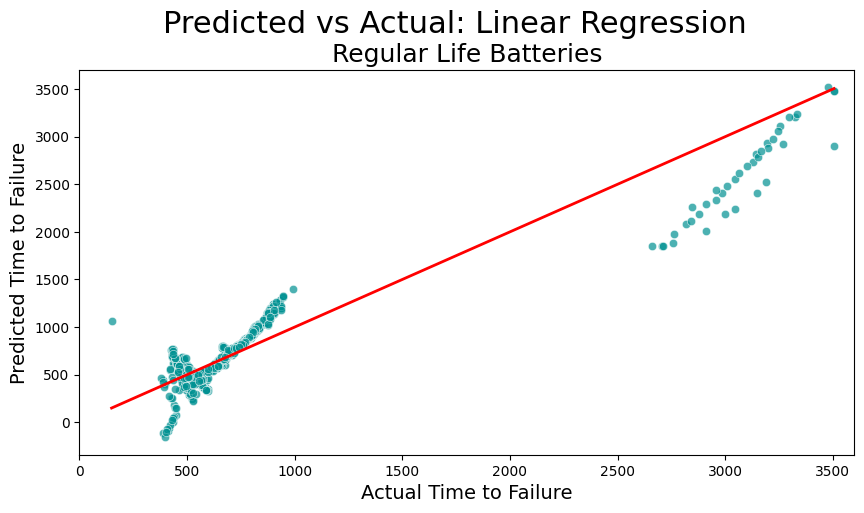

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.scatterplot(x=regtest_lr,y=regpred_lr, color='#009192',alpha=0.7)
plt.plot([regtest_lr.min(), regtest_lr.max()], [regtest_lr.min(), regtest_lr.max()], color='red', linewidth=2)
# Plot details
plt.xlabel(' ')
plt.ylabel('Predicted Time to Failure',fontsize=14)
plt.title('Regular Life Batteries',fontsize = 18)
plt.suptitle('Predicted vs Actual: Linear Regression',fontsize=22,y=1)
plt.xlabel('Actual Time to Failure',fontsize=14)
plt.xlim(0,3600)

# Show plot
plt.show()

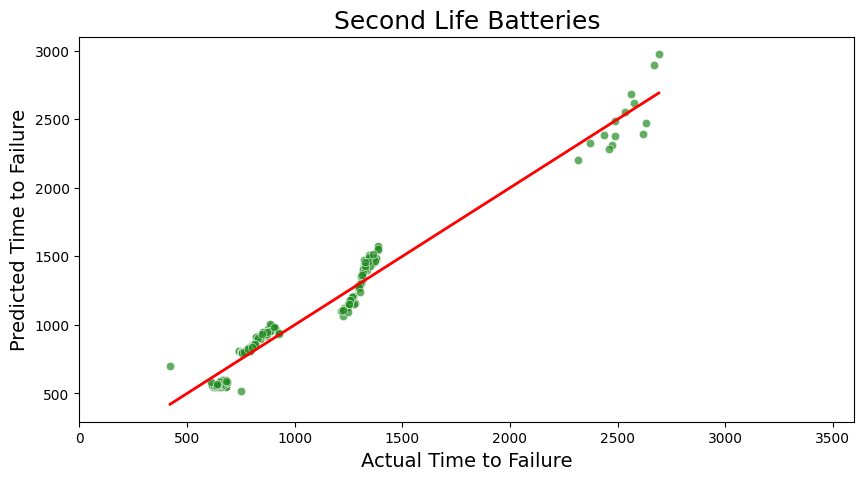

In [16]:
plt.figure(figsize=(10,5))
#sns.scatterplot(x=y_test,y=y_pred_rf, color='forestgreen',alpha=0.7)
plt.plot([sectest_lr.min(), sectest_lr.max()], [sectest_lr.min(), sectest_lr.max()], color='red', linewidth=2)
sns.scatterplot(x=sectest_lr,y=secpred_lr, color='forestgreen',alpha=0.7)
# Plot details
plt.xlabel('Actual Time to Failure',fontsize=14)
plt.ylabel('Predicted Time to Failure',fontsize=14)
plt.title('Second Life Batteries',fontsize = 18)
#plt.suptitle('Predicted vs Actual: Linear Regression',fontsize=22,y=1)
plt.xlim(0,3600)

# Show plot
plt.show()

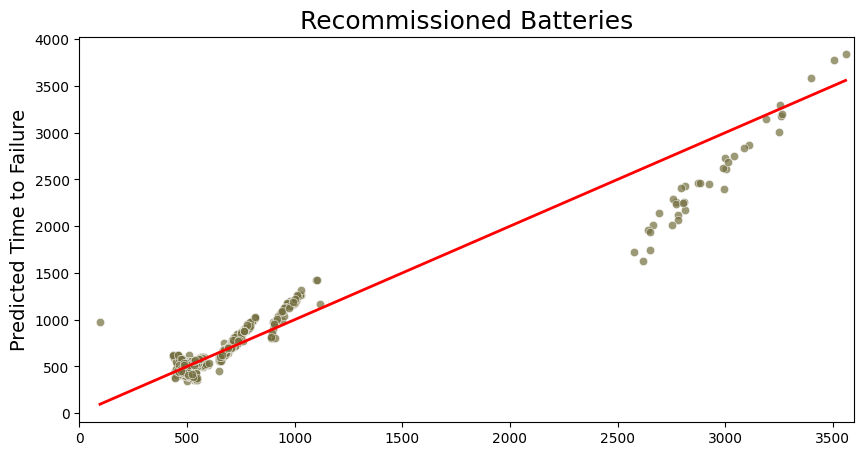

In [17]:
plt.figure(figsize=(10,5))
sns.scatterplot(x=recomtest_lr,y=recompred_lr, color='#736e3e',alpha=0.7)
plt.plot([recomtest_lr.min(), recomtest_lr.max()], [recomtest_lr.min(), recomtest_lr.max()], color='red', linewidth=2)
# Plot details
plt.xlabel(' ')
plt.ylabel('Predicted Time to Failure',fontsize=14)
#plt.xlabel('Actual Time to Failure',fontsize=14)
plt.title('Recommissioned Batteries',fontsize = 18)
plt.xlim(0,3600)

# Show plot
plt.show()

## Random Forest

### Regular Batteries

In [18]:
from sklearn.ensemble import RandomForestRegressor

def randomForest(df):
    '''
    Takes in a dataframe builds a random forest model with relevant metrics
    
    Parameters:
    df (dataFrame): input df of battery data
    
    Returns:
    y_test: test values
    y_pred_rf: predicted values
    rf_mse: Mean squared error
    rf_aic: Akaike information criterion
    rf_r2: R squared
    '''
    X = df[['arrhenius_temperature' , 'log_voltage' , 'current_load' , 'temp_volt']]
    y = df['time_end']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf_model = RandomForestRegressor(random_state = 42)
    rf_model.fit(X_train, y_train)

    #predictions
    y_pred_rf = rf_model.predict(X_test)

    #evaluation
    rf_mse = mean_squared_error(y_test, y_pred_rf)
    rf_r2 = r2_score(y_test, y_pred_rf)
    n = len(y_test)
    rss = np.sum((y_test-y_pred_rf)**2)
    k = X_train.shape[1] + 1
    rf_aic = n * np.log(rss / n) +2 * k

    #train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    return y_test, y_pred_rf, rf_mse, rf_aic, rf_r2

### Model Building

In [19]:
regtest, regpred_rf, rf_mse_reg, rf_aic_reg, rf_r2_reg = randomForest(regular)
sectest, secpred_rf, rf_mse_sec, rf_aic_sec, rf_r2_sec = randomForest(second)
recomtest, recompred_rf, rf_mse_recom, rf_aic_recom, rf_r2_recom = randomForest(recomissioned)

In [20]:
print(f'Regular MSE, Random Forest: {rf_mse_reg}')
print(f'Regular AIC, Random Forest: {rf_aic_reg}')
print(f'Regular R2, Random Forest: {rf_r2_reg}')
print('-------------------')
print(f'Second Life MSE, Random Forest: {rf_mse_sec}')
print(f'Second Life AIC, Random Forest: {rf_aic_sec}')
print(f'Second Life R2, Random Forest: {rf_r2_sec}')
print('-------------------')
print(f'Recommissioned MSE, Random Forest: {rf_mse_recom}')
print(f'Recommissioned AIC, Random Forest: {rf_aic_recom}')
print(f'Recommissioned R2, Random Forest: {rf_r2_recom}')

Regular MSE, Random Forest: 927.0710906956009
Regular AIC, Random Forest: 5127.19065846145
Regular R2, Random Forest: 0.997043533925981
-------------------
Second Life MSE, Random Forest: 298.80842729491457
Second Life AIC, Random Forest: 1600.2449412079122
Second Life R2, Random Forest: 0.9984042973097362
-------------------
Recommissioned MSE, Random Forest: 75.72597406872131
Recommissioned AIC, Random Forest: 3151.4900057700097
Recommissioned R2, Random Forest: 0.9997401010973765


### Random Forest Visualizations

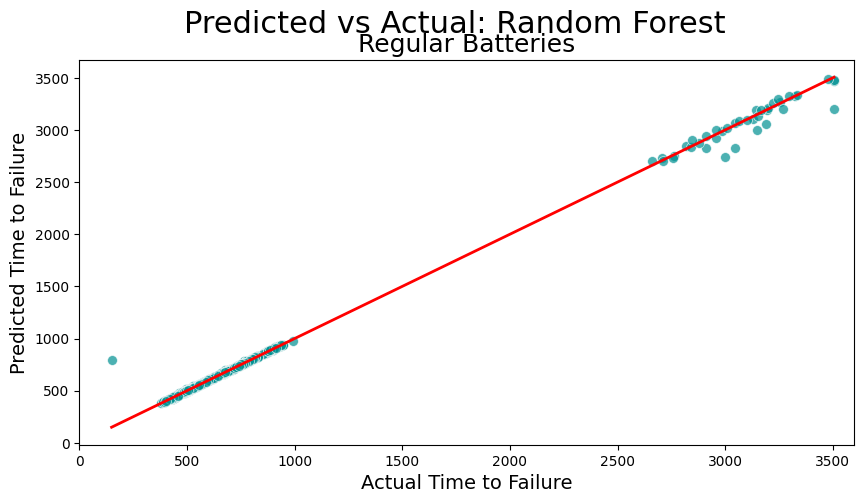

In [21]:
plt.figure(figsize=(10,5))
sns.scatterplot(x=regtest,y=regpred_rf, color='#009192',alpha=0.7,s=50)
plt.plot([regtest.min(), regtest.max()], [regtest.min(), regtest.max()], color='red', linewidth=2)
# Plot details
plt.xlabel('Actual Time to Failure',fontsize=14)
plt.ylabel('Predicted Time to Failure',fontsize=14)
plt.title('Regular Batteries',fontsize = 18)
plt.suptitle('Predicted vs Actual: Random Forest', fontsize=22)
plt.xlim(0,3600)

# Show plot
plt.show()

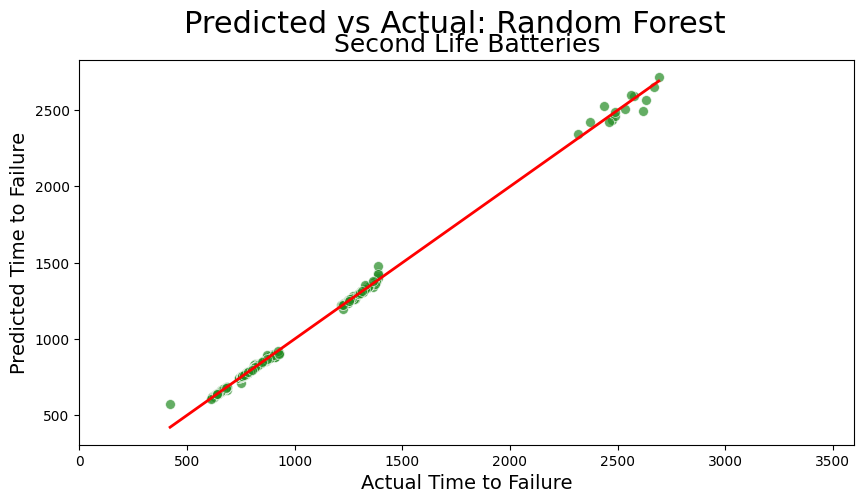

In [22]:
plt.figure(figsize=(10,5))
sns.scatterplot(x=sectest,y=secpred_rf, color='forestgreen',alpha=0.7,s=50)
plt.plot([sectest.min(), sectest.max()], [sectest.min(), sectest.max()], color='red', linewidth=2)
plt.suptitle('Predicted vs Actual: Random Forest', fontsize=22)
plt.xlabel('Actual Time to Failure',fontsize=14)
plt.ylabel('Predicted Time to Failure',fontsize=14)
plt.title('Second Life Batteries',fontsize = 18)
plt.xlim(0,3600)

plt.show()

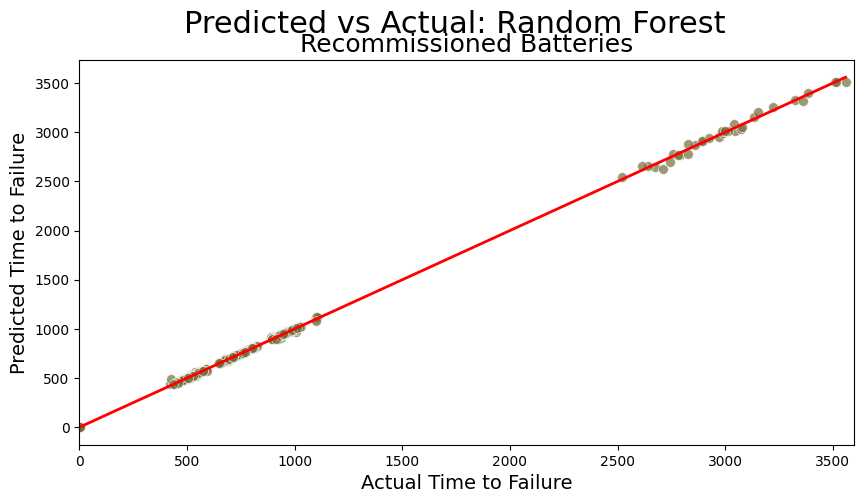

In [23]:
plt.figure(figsize=(10,5))
sns.scatterplot(x=recomtest,y=recompred_rf, color='#736e3e',alpha=0.7,s=50)
plt.plot([recomtest.min(), recomtest.max()], [recomtest.min(), recomtest.max()], color='red', linewidth=2)

plt.xlabel('Actual Time to Failure',fontsize=14)
plt.ylabel('Predicted Time to Failure',fontsize=14)
plt.title('Recommissioned Batteries',fontsize = 18)
plt.suptitle('Predicted vs Actual: Random Forest', fontsize=22)
plt.xlim(0,3600)

plt.show()

## Neural Networks

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [31]:
def neuralNetwork(df):
    '''
    Takes in a dataframe builds a neural network model with relevant metrics
    
    Parameters:
    df (dataFrame): input df of battery data
    
    Returns:
    y_test: test values
    y_pred: predicted values
    loss: Mean squared error
    aic: Akaike information criterion
    r2: R squared
    '''
    X = df[['arrhenius_temperature', 'log_voltage', 'current_load', 'temp_volt']]
    y = df['time_end']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    print(X_train_scaled.shape)
    print(y_train.shape)

    # Define the FNN model
    model = Sequential([
        Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'),
        Dropout(0.2),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dense(1)  # Output layer for predicting time to failure
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    # Train the model
    model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=50, batch_size=32)

    test_loss, test_mae = model.evaluate(X_test_scaled, y_test)
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)

    # Calculate r2 and AIC
    r2 = r2_score(y_test,y_pred)

    n = len(y_test)
    rss = np.sum((y_test - y_pred.reshape(-1))**2)
    k = len(model.trainable_weights) + 1
    aic = n * np.log(rss/n) + 2 * k

    # Make predictions
    y_pred = model.predict(X_test_scaled)

    return y_test, y_pred, test_loss, test_mae, aic, r2

In [32]:
regtest_nn, regpred_nn, regtest_loss, regmae, regaic_nn, regr2_nn = neuralNetwork(regular)
sectest_nn, secpred_nn, sectest_loss, secmae, secaic_nn, secr2_nn = neuralNetwork(second)
recomtest_nn, recompred_nn, recomtest_loss, recomae, recomaic_nn, recomr2_nn = neuralNetwork(recommissioned)

(2995, 4)
(2995,)
Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 789368.1250 - mae: 735.3321 - val_loss: 679423.7500 - val_mae: 628.3295
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step - loss: 436054.0312 - mae: 487.9448 - val_loss: 52104.4922 - val_mae: 184.0077
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 631us/step - loss: 65405.7812 - mae: 185.9821 - val_loss: 39879.9922 - val_mae: 151.1147
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step - loss: 59509.3555 - mae: 162.3488 - val_loss: 36607.8711 - val_mae: 137.6056
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 624us/step - loss: 55617.5859 - mae: 152.7226 - val_loss: 32259.3359 - val_mae: 138.6852
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 643us/step - loss: 54384.5938 - mae: 151.2776 - val_loss: 30636.8223 - val_mae: 133.1682
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step - loss: 49131.8555 - mae: 148.4020 - val_loss: 28558.6738 - val_mae: 133.8254
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/step - loss: 38174.7070 

### Neural Network Test Metrics

In [33]:
print(f'Regular MSE, Neural Network: {regtest_loss}')
print(f'Regular MAE, Neural Network: {regmae}')
print(f'Regular AIC, Neural Network: {regaic_nn}')
print(f'Regular R2, Neural Network: {regr2_nn}')
print('-------------------')
print(f'Second Life MSE, Neural Network: {sectest_loss}')
print(f'Second Life MAE, Neural Network: {secmae}')
print(f'Second Life AIC, Neural Network: {secaic_nn}')
print(f'Second Life R2, Neural Network: {secr2_nn}')
print('-------------------')
print(f'Recommissioned MSE, Neural Network: {recomtest_loss}')
print(f'Recommissioned MAE, Neural Network: {recomae}')
print(f'Recommissioned AIC, Neural Network: {recomaic_nn}')
print(f'Recommissioned R2, Neural Network: {recomr2_nn}')

Regular MSE, Neural Network: 1726.2886962890625
Regular MAE, Neural Network: 21.137840270996094
Regular AIC, Neural Network: 5600.843021120686
Regular R2, Neural Network: 0.9944947982956732
-------------------
Second Life MSE, Neural Network: 2385.523193359375
Second Life MAE, Neural Network: 34.24570083618164
Second Life AIC, Neural Network: 2187.8315257354634
Second Life R2, Neural Network: 0.987260779435566
-------------------
Recommissioned MSE, Neural Network: 1524.888916015625
Recommissioned MAE, Neural Network: 23.36446762084961
Recommissioned AIC, Neural Network: 5207.411189568202
Recommissioned R2, Neural Network: 0.9948156100774164


### Neural Network Visualizations

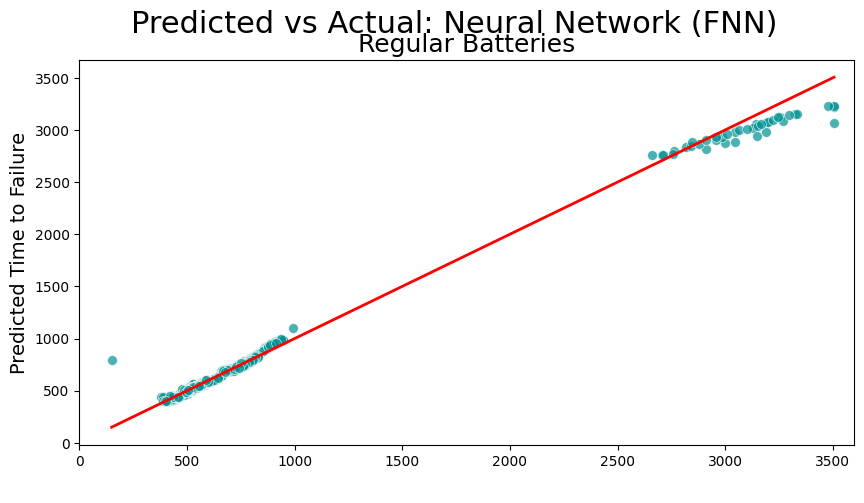

In [28]:
plt.figure(figsize=(10,5))
sns.scatterplot(x=regtest_nn,y=regpred_nn.flatten(), color='#009192',alpha=0.7,s=50)
plt.plot([regtest_nn.min(), regtest_nn.max()], [regtest_nn.min(), regtest_nn.max()], color='red', linewidth=2)

plt.xlabel('Actual Time to Failure',fontsize=14)
plt.ylabel('Predicted Time to Failure',fontsize=14)
plt.title('Regular Batteries',fontsize = 18)
plt.suptitle('Predicted vs Actual: Neural Network (FNN)', fontsize=22)
plt.xlabel(' ')
plt.xlim(0,3600)

plt.show()

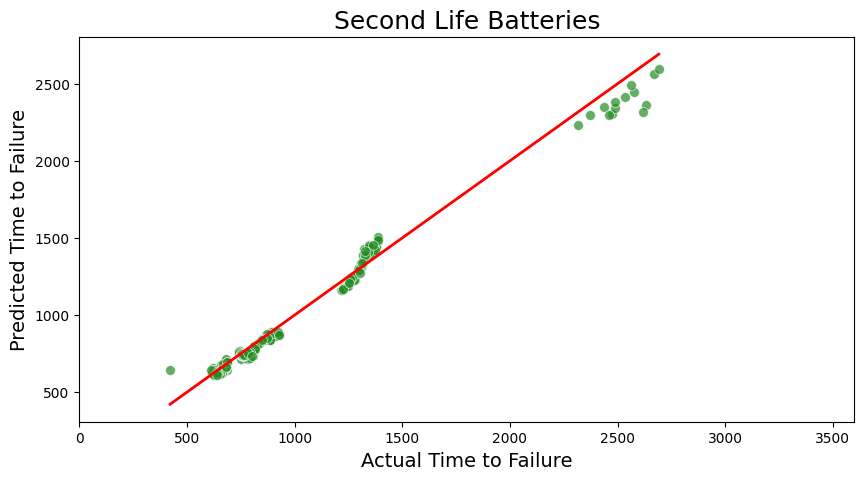

In [29]:
plt.figure(figsize=(10,5))
sns.scatterplot(x=sectest_nn,y=secpred_nn.flatten(), color='forestgreen',alpha=0.7,s=50)
plt.plot([sectest_nn.min(), sectest_nn.max()], [sectest_nn.min(), sectest_nn.max()], color='red', linewidth=2)

plt.xlabel('Actual Time to Failure',fontsize=14)
plt.ylabel('Predicted Time to Failure',fontsize=14)
plt.title('Second Life Batteries',fontsize = 18)
#plt.suptitle('Predicted vs Actual: Neural Network (FNN)', fontsize=22)
plt.xlim(0,3600)

plt.show()

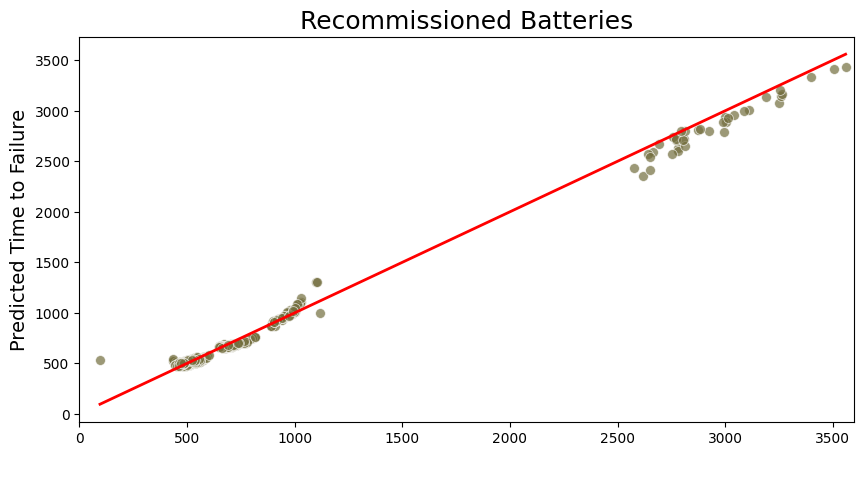

In [30]:
plt.figure(figsize=(10,5))
sns.scatterplot(x=recomtest_nn,y=recompred_nn.flatten(), color='#736e3e',alpha=0.7,s=50)
plt.plot([recomtest_nn.min(), recomtest_nn.max()], [recomtest_nn.min(), recomtest_nn.max()], color='red', linewidth=2)

plt.xlabel('Actual Time to Failure',fontsize=14)
plt.ylabel('Predicted Time to Failure',fontsize=14)
plt.title('Recommissioned Batteries',fontsize = 18)
#plt.suptitle('Predicted vs Actual: Neural Network (FNN)', fontsize=22)
plt.xlim(0,3600)
plt.xlabel(' ')

plt.show()